In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-08-20 12:49:59.933183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755694200.121536      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755694200.177405      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = "/kaggle/input/data-256-256-new/data_256_256_new"

In [3]:
df = pd.read_excel(f"{base_dir}/labels.xlsx")

# full file paths
df["filepath"] = df["id"].apply(lambda x: os.path.join(base_dir, x))
print(df.head())

                id label                                           filepath
0  Red/Red (1).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
1  Red/Red (2).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
2  Red/Red (3).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
3  Red/Red (4).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
4  Red/Red (5).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...


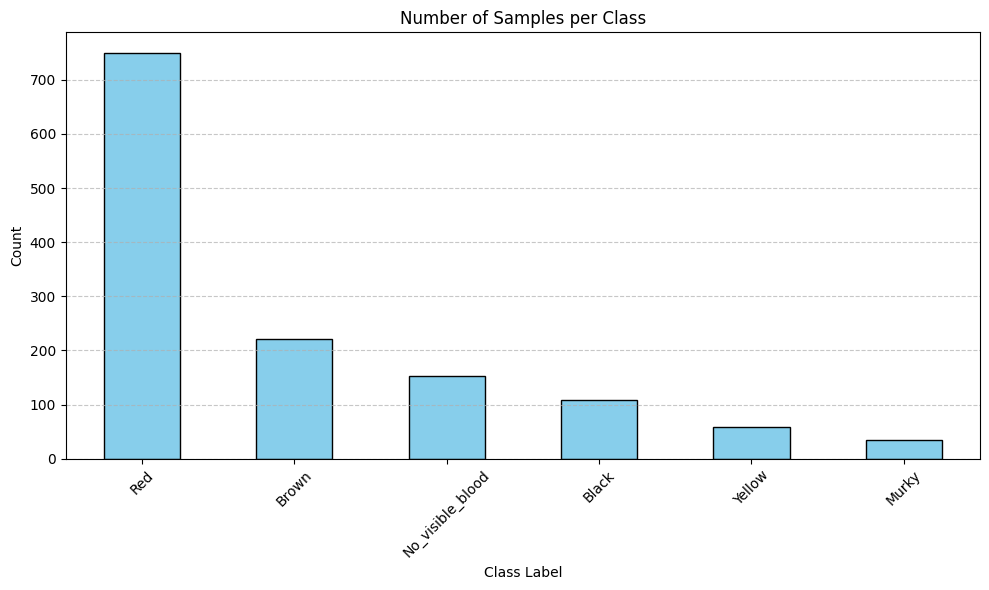

In [4]:
class_counts = df['label'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Samples per Class')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Pre-Processing

In [5]:
print("Loading images...")
images = []
labels = []
for i, row in df.iterrows():
    try:
        img = load_img(row["filepath"], target_size=(256, 256))
        img_array = img_to_array(img) / 255.0  # normalize
        images.append(img_array)
        labels.append(row["label"])
        
        if (i + 1) % 100 == 0:
            print(f"Loaded {i + 1} images.")
    except Exception as e:
        print(f"Error loading {row['filepath']}: {e}")

Loading images...
Loaded 100 images.
Loaded 200 images.
Loaded 300 images.
Loaded 400 images.
Loaded 500 images.
Loaded 600 images.
Loaded 700 images.
Loaded 800 images.
Loaded 900 images.
Loaded 1000 images.
Loaded 1100 images.
Loaded 1200 images.
Loaded 1300 images.


In [6]:
images = np.array(images)
labels = np.array(labels)
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

Images shape: (1325, 256, 256, 3), Labels shape: (1325,)


In [7]:
# Encode labels
le = LabelEncoder()
labels_int = le.fit_transform(labels)
labels_onehot = to_categorical(labels_int)

print("Integer labels (first 5):", labels_int[:5])
print("One-hot labels (first 5):", labels_onehot[:5])
print("Classes:", le.classes_)

num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")

Integer labels (first 5): [4 4 4 4 4]
One-hot labels (first 5): [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]
Classes: ['Black' 'Brown' 'Murky' 'No_visible_blood' 'Red' 'Yellow']
Number of classes: 6


## Split

In [8]:
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test, labels_temp, labels_test = train_test_split(
    images, labels_onehot, labels_int, 
    test_size=0.2, random_state=42, stratify=labels_int
)

In [9]:
X_train, X_val, y_train, y_val, labels_train, labels_val = train_test_split(
    X_temp, y_temp, labels_temp,
    test_size=0.25, random_state=42, stratify=labels_temp  
)

In [10]:
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (795, 256, 256, 3), (795, 6)
Validation set: (265, 256, 256, 3), (265, 6)
Test set: (265, 256, 256, 3), (265, 6)


## Model

In [11]:
import tensorflow.keras.backend as K
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal Loss for addressing class imbalance
    alpha: weighting factor for rare class (default 0.25)
    gamma: focusing parameter (default 2.0)
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1 - epsilon)
        
        # calculate cross entropy
        ce = -y_true * K.log(y_pred)
        
        # calculate focal weight: (1-pt)^gamma
        pt = K.sum(y_true * y_pred, axis=-1, keepdims=True)
        focal_weight = K.pow(1 - pt, gamma)
        
        # alpha weighting
        alpha_weight = y_true * alpha + (1 - y_true) * (1 - alpha)
        
        # components
        focal = alpha_weight * focal_weight * ce
        return K.mean(K.sum(focal, axis=-1))
    
    return focal_loss_fixed

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [13]:
# classifier head for all models
def create_classifier_head(base_model, num_classes):
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [14]:
def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = True
    return create_classifier_head(base_model, num_classes)

In [15]:
model = create_resnet_model((256, 256, 3), num_classes)
model_name = "ResNet50"

model.compile(
    optimizer=Adam(learning_rate=0.0001),  # lower learning rate since using pretrained weights
    loss=focal_loss(alpha=0.25, gamma=2.0),  
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1755694295.218083      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755694295.218706      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,777,862 (94.52 MB)

 Trainable params: 24,720,646 (94.30 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [16]:
# Callbacks
checkpoint = ModelCheckpoint(
    f'best_{model_name.lower()}_focal.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-8,
    verbose=1
)

In [17]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30


I0000 00:00:1755694359.205280     107 service.cc:148] XLA service 0x7e5b540068e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755694359.205888     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755694359.205908     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755694363.964615     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755694384.191184     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.4392 - loss: 0.3209
Epoch 1: val_accuracy improved from -inf to 0.56604, saving model to best_resnet50_focal.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 117s 864ms/step - accuracy: 0.4411 - loss: 0.3196 - val_accuracy: 0.5660 - val_loss: 0.2414 - learning_rate: 1.0000e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7012 - loss: 0.1292
Epoch 2: val_accuracy did not improve from 0.56604
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.7009 - loss: 0.1294 - val_accuracy: 0.5660 - val_loss: 0.9699 - learning_rate: 1.0000e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7807 - loss: 0.0958
Epoch 3: val_accuracy did not improve from 0.56604
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.7804 - loss: 0.0959 - val_accuracy: 0.5660 - val_loss: 1.6728 - learning_rate: 1.0000e-04
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7912 - loss: 0.0912
Epoch 4: val_accuracy did not impr

In [18]:
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Train Accuracy: {accuracy*100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 318ms/step - accuracy: 0.5895 - loss: 0.2277
Train Accuracy: 56.60%


In [19]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5694 - loss: 0.2474
Validation Accuracy: 56.60%


## Loss and Accuracy Matrices

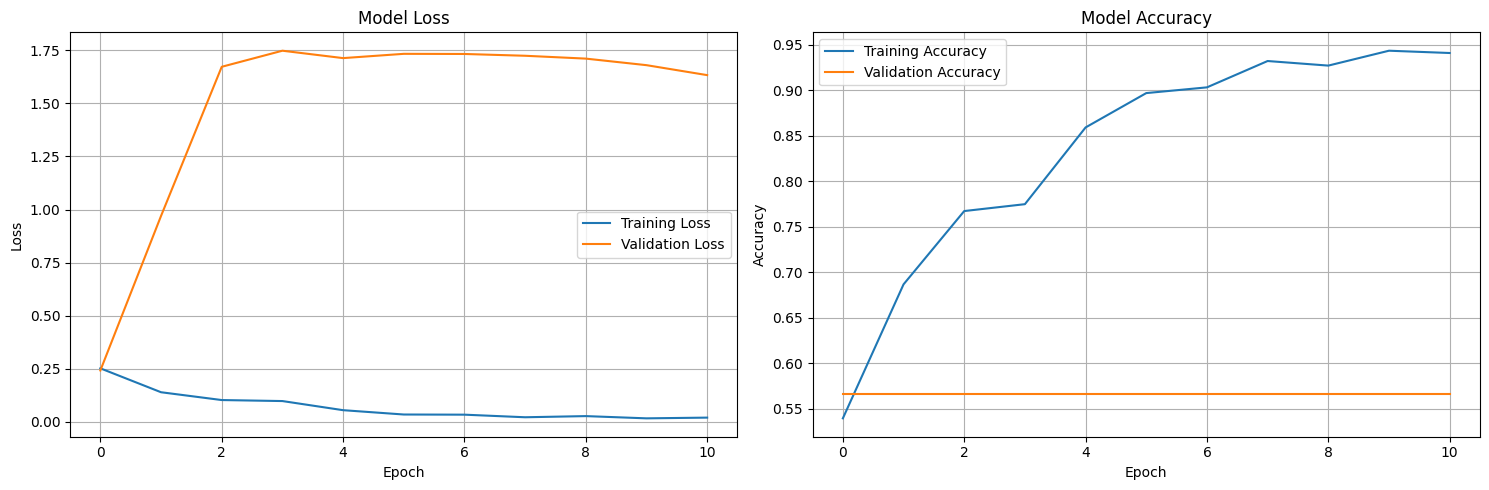

In [20]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Other Matrices

In [21]:
# Load the best model
best_model = tf.keras.models.load_model(
    f'best_{model_name.lower()}_focal.h5',
    custom_objects={'focal_loss_fixed': focal_loss()}
)

In [22]:
train_preds = np.argmax(best_model.predict(X_train, batch_size=16), axis=1)
val_preds = np.argmax(best_model.predict(X_val, batch_size=16), axis=1)
test_preds = np.argmax(best_model.predict(X_test, batch_size=16), axis=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


In [23]:
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)
y_test_int = np.argmax(y_test, axis=1)

In [24]:
train_accuracy = np.mean(y_train_int == train_preds)
val_accuracy = np.mean(y_val_int == val_preds)
test_accuracy = np.mean(y_test_int == test_preds)

print(f"\nFinal Results using Pretrained {model_name} with Focal Loss:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Final Results using Pretrained ResNet50 with Focal Loss:
Train Accuracy: 0.5660
Validation Accuracy: 0.5660
Test Accuracy: 0.5660


In [25]:
# Detailed classification report for test set
print("\n=== Train Set Classification Report ===")
print(classification_report(y_train_int, train_preds, target_names=le.classes_))


=== Train Set Classification Report ===
                  precision    recall  f1-score   support

           Black       0.00      0.00      0.00        65
           Brown       0.00      0.00      0.00       134
           Murky       0.00      0.00      0.00        20
No_visible_blood       0.00      0.00      0.00        92
             Red       0.57      1.00      0.72       450
          Yellow       0.00      0.00      0.00        34

        accuracy                           0.57       795
       macro avg       0.09      0.17      0.12       795
    weighted avg       0.32      0.57      0.41       795



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Detailed classification report for test set
print("\n=== Validation Set Classification Report ===")
print(classification_report(y_val_int, val_preds, target_names=le.classes_))


=== Validation Set Classification Report ===
                  precision    recall  f1-score   support

           Black       0.00      0.00      0.00        22
           Brown       0.00      0.00      0.00        44
           Murky       0.00      0.00      0.00         7
No_visible_blood       0.00      0.00      0.00        30
             Red       0.57      1.00      0.72       150
          Yellow       0.00      0.00      0.00        12

        accuracy                           0.57       265
       macro avg       0.09      0.17      0.12       265
    weighted avg       0.32      0.57      0.41       265



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Detailed classification report for test set
print("\n=== Test Set Classification Report ===")
print(classification_report(y_test_int, test_preds, target_names=le.classes_))


=== Test Set Classification Report ===
                  precision    recall  f1-score   support

           Black       0.00      0.00      0.00        22
           Brown       0.00      0.00      0.00        44
           Murky       0.00      0.00      0.00         7
No_visible_blood       0.00      0.00      0.00        30
             Red       0.57      1.00      0.72       150
          Yellow       0.00      0.00      0.00        12

        accuracy                           0.57       265
       macro avg       0.09      0.17      0.12       265
    weighted avg       0.32      0.57      0.41       265



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


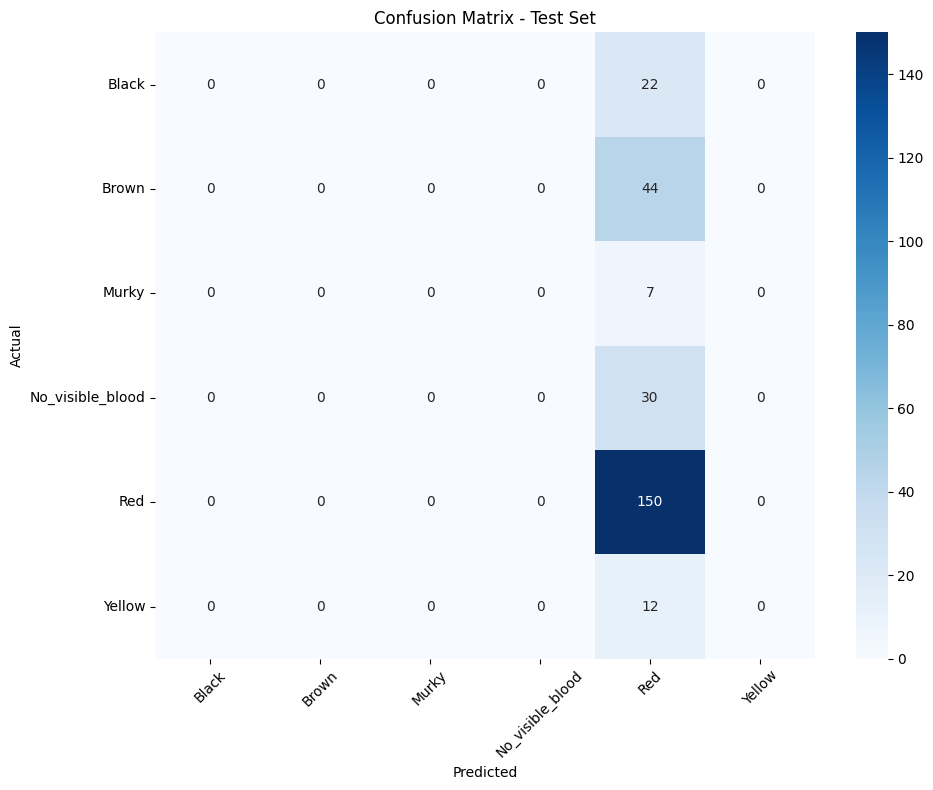

In [28]:
# Confusion Matrix for test set
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_int, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()